In [1]:
import time

start_time = time.time()
import jax
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import scipy.io
from collections import namedtuple
import time
from functools import partial
import matplotlib.pyplot as plt
from init_RR import load_data, setup_model, mmt,plotyield
import jax
import optax

[data, date, yielddata, yieldmaturity, infl, x, cy_diff, ynom15y, ynom20y, ynom30y] = load_data()
nparam = 20

In [2]:
import jax
devices = jax.devices()
device = devices[0]  # Assuming you have at least one device
print(device)

cuda:0


In [3]:
start_time = time.time()
# values of convenience yields
allcy = [i * 0.05 for i in range(int(2.5 / 0.05) + 1)]
cylen = len(allcy)

# Load results.mat equivalent in Python
results = scipy.io.loadmat('results.mat')
# Extracting data from results (assuming similar structure)
minparamval = results['minparamval']
maxval = len(minparamval[0])

idx = 0
cy = allcy[idx] * cy_diff
param = minparamval[:, idx]

# Setup model (assuming setup_model returns these values)
(N, T, Psi, Sig, I_pi, I_gdp, I_y1, I_yspr, I_cy, inflpos, gdppos, y1pos, 
 ysprpos, pi0, x0, ynom1q0, yspr0, cy0, X2, yielddata, yieldmaturity, eps2) = setup_model(yielddata, yieldmaturity, cy, [], [], infl, x, [], [])

Data = data(Psi, Sig, I_pi, I_gdp, I_y1, I_yspr, I_cy, inflpos, gdppos, y1pos,ysprpos, pi0, x0, ynom1q0, yspr0, cy0, X2, yielddata, yieldmaturity, eps2)

# Call the mmt function with these parameters
result = mmt(param,N,T,Data)
# Process or print the result as needed
print(result) 
end_time = time.time()
print("Elapsed time:", end_time - start_time)

1370.4062
Elapsed time: 3.3763394355773926


In [4]:
np.min(minparamval[:,0])

-0.3376673611484112

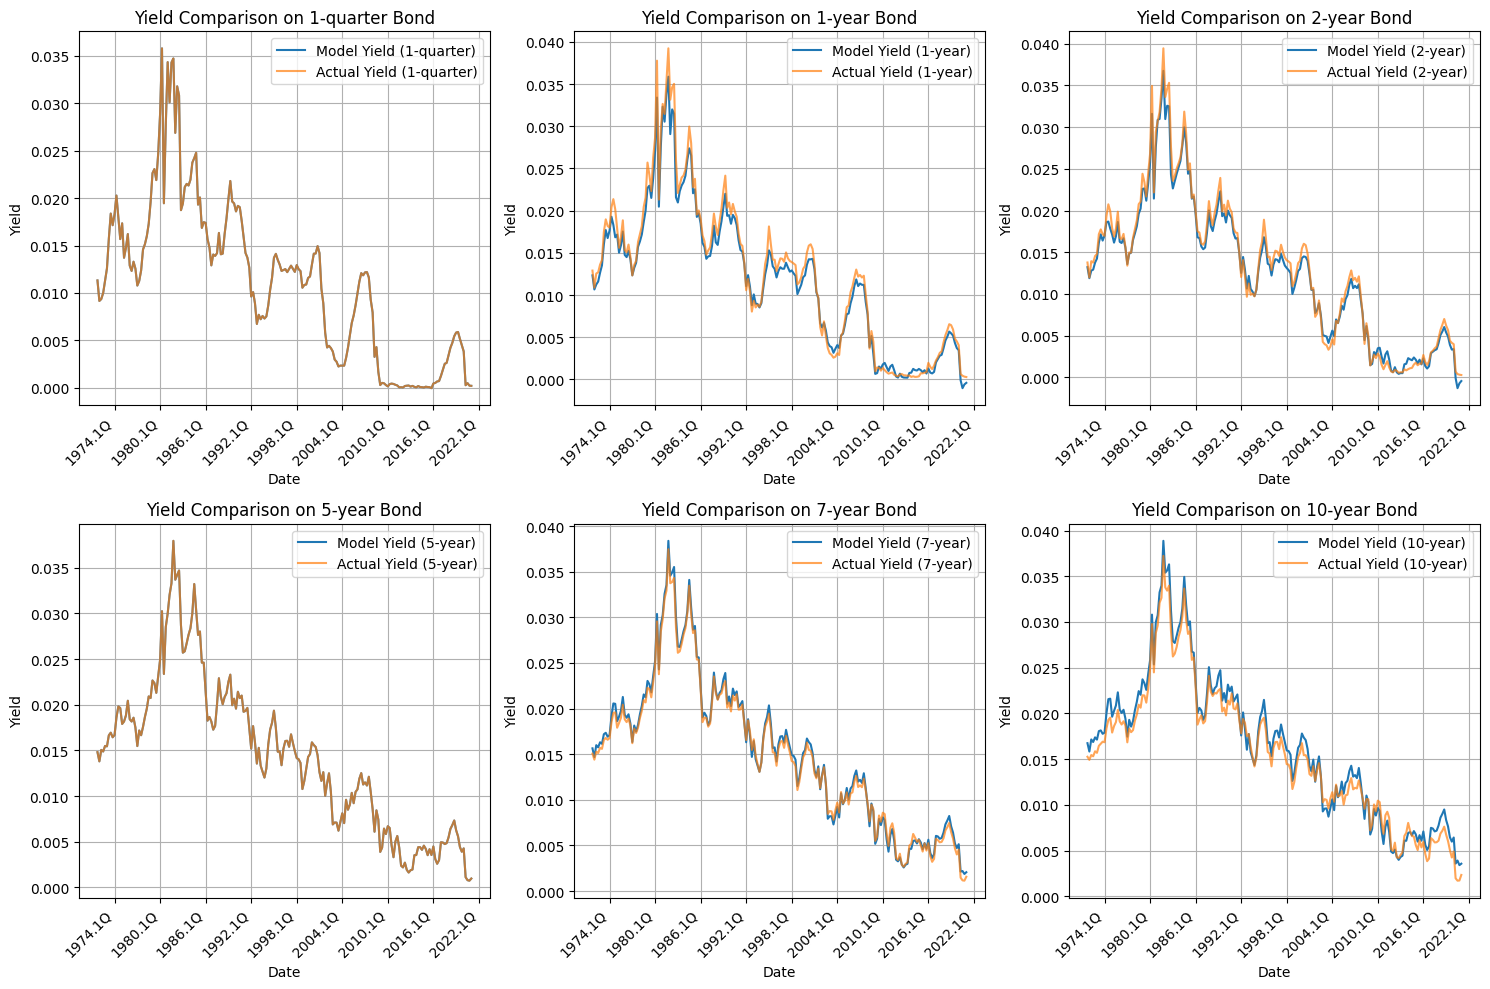

In [5]:
plotyield(param, N, T, Data)

In [6]:
# main
adam = optax.adam(learning_rate=.001)
losses = []

minparamval = results['minparamval']
maxval = len(minparamval[0])

idx = 0
cy = allcy[idx] * cy_diff
param = minparamval[:, idx]
param1 = param
opt_state = adam.init(param1)
# mmt(param1,N,T,Data)

steps = 1
for i in range(steps):
    loss, gradient = jax.value_and_grad(mmt)(param1, N,T,Data)
    print(loss)
    updates, opt_state = adam.update(gradient, opt_state)
    param1 += updates
    losses.append(loss)
    if ((i+1) % 1 == 0):
        print(f"Step {i}, loss {loss}")

# save both opt_state and param1 into a file

1370.4062
Step 0, loss 1370.40625


In [14]:
import jax
import jax.numpy as jnp
import optax
from functools import partial
import pickle

def optimize_mmt(N, T, Data, num_points, mean, sd, steps_per_phase, num_phases, checkpoint_interval, init_learning_rate, learning_rate_decay, decay_interval, init_param=None):
    # Generate random starting points
    key = jax.random.PRNGKey(0)
    param_shape = (num_points,) + mean.shape
    
    if init_param is not None:
        # Use the provided init_param as one of the starting points
        params = jnp.concatenate([init_param[jnp.newaxis, :], mean[jnp.newaxis, :] + sd[jnp.newaxis, :] * jax.random.normal(key, shape=(num_points - 1,) + mean.shape)], axis=0)
    else:
        # Initialize all starting points randomly
        params = mean[jnp.newaxis, :] + sd[jnp.newaxis, :] * jax.random.normal(key, shape=param_shape)
    
    # Initialize optimizer states
    learning_rate = init_learning_rate
    my_optim = optax.adam(learning_rate=learning_rate)
    opt_states = jax.vmap(my_optim.init)(params)
    
    # Pre-compute the value and gradient function
    value_and_grad_fn = jax.value_and_grad(mmt)
    
    best_param = None
    best_loss = jnp.inf
    
    for phase in range(num_phases):
        if phase > 0 and phase % decay_interval == 0:
            learning_rate *= learning_rate_decay
            my_optim = optax.adam(learning_rate=learning_rate)
            opt_states = jax.vmap(my_optim.init)(params)
        
        for step in range(steps_per_phase):
            losses, gradients = jax.vmap(value_and_grad_fn, in_axes=(0, None, None, None))(params, N, T, Data)

            # # Gradient clipping
            # global_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(gradients)))
            # gradients = jax.tree.map(lambda g: g * jnp.minimum(1.0, 1.0 / global_norm), gradients)

            updates, opt_states = jax.vmap(my_optim.update)(gradients, opt_states)
            params += updates
            
            # Check for NaN values in params and replace with new random draws
            nan_mask = jnp.any(jnp.isnan(params), axis=1)
            if jnp.any(nan_mask):
                key, subkey = jax.random.split(key)
                params = jnp.where(nan_mask[:, jnp.newaxis], mean[jnp.newaxis, :] + sd[jnp.newaxis, :] * jax.random.normal(subkey, shape=param_shape), params)
            
            if step % checkpoint_interval == 0:
                min_loss_idx = jnp.nanargmin(losses)
                min_loss = losses[min_loss_idx]
                if min_loss < best_loss:
                    best_param = params[min_loss_idx]
                    best_loss = min_loss
                print(f"Phase {phase}, Step {step}, Best loss: {best_loss}, Learning rate: {learning_rate}")
                # Save the best parameter and loss to a file or checkpoint here
                with open('param1.pkl') as handle:
                    pickle.dump(best_param, best_loss, handle)


        
        # Select the best point and add noise for half of the points
        best_idx = jnp.nanargmin(losses)
        best_point = params[best_idx]
        key, subkey = jax.random.split(key)
        noise = 0.001 * jax.random.normal(subkey, shape=param_shape)
        mask = jnp.arange(num_points) < num_points // 2
        params = jnp.where(mask[:, jnp.newaxis], best_point + noise, mean + sd * jax.random.normal(key, shape=param_shape))
    
    return best_param, best_loss

# Set the number of points, mean, standard deviation, and other parameters
num_points = 2000
mean = jnp.zeros_like(param)
sd = jnp.ones_like(param)
steps_per_phase = 10000
num_phases = 25
checkpoint_interval = 1000
init_learning_rate = 0.01
learning_rate_decay = 0.75
decay_interval = 1

# Use param as the initial starting point
# init_param = param
# best_param, best_loss = optimize_mmt(N, T, Data, num_points, mean, sd, steps_per_phase, num_phases, checkpoint_interval, init_learning_rate, learning_rate_decay, decay_interval, init_param=init_param)

# All Random
best_param, best_loss = optimize_mmt(N, T, Data, num_points, mean, sd, steps_per_phase, num_phases, checkpoint_interval, init_learning_rate, learning_rate_decay, decay_interval)

Phase 0, Step 0, Best loss: 310718016.0, Learning rate: 0.01
Phase 0, Step 1000, Best loss: 12132.234375, Learning rate: 0.01
Phase 0, Step 2000, Best loss: 10727.576171875, Learning rate: 0.01
Phase 0, Step 3000, Best loss: 10650.5537109375, Learning rate: 0.01
Phase 0, Step 4000, Best loss: 10650.5537109375, Learning rate: 0.01
Phase 0, Step 5000, Best loss: 10650.5537109375, Learning rate: 0.01
Phase 0, Step 6000, Best loss: 10650.5537109375, Learning rate: 0.01
Phase 0, Step 7000, Best loss: 10614.048828125, Learning rate: 0.01
Phase 0, Step 8000, Best loss: 10602.94921875, Learning rate: 0.01
Phase 0, Step 9000, Best loss: 10602.94921875, Learning rate: 0.01
Phase 1, Step 0, Best loss: 10602.94921875, Learning rate: 0.0075
Phase 1, Step 1000, Best loss: 10571.634765625, Learning rate: 0.0075
Phase 1, Step 2000, Best loss: 10569.5732421875, Learning rate: 0.0075
Phase 1, Step 3000, Best loss: 10559.3056640625, Learning rate: 0.0075
Phase 1, Step 4000, Best loss: 10551.3427734375, L